In [1]:
# in this python workbook, I will do the below

# EDA - with helper functions
# dendrogram to see correlation on columns
# Partial Dependence plots to see interactions of features in model
# Model tuning - lasso vs elastic net - using RandomSearchCV (speed) then GridsearchCv (extensive search)
# feature selection with Hypothesis testing (SelectKBest) with f_regression and mutual info regression, feature importances from RF (SelectFromModel)
# residual plots
# feature engineering with polynomial features
# feature selection...again..this time with Boruta (performs worse than other methods)
# final residual plot


In [2]:
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from math import ceil
from rfpimp import feature_corr_matrix
from sklearn.model_selection import (
    cross_val_score,
    RepeatedKFold,
    GridSearchCV,RandomizedSearchCV
)
import warnings

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet


In [3]:
# plot functions

def df_datatypes(dataframe):
    print(dataframe.columns.to_series().groupby(dataframe.dtypes).groups)
    
def missing(dataframe, graph=False):
    dataframe_na = (dataframe.isnull().sum() / len(dataframe)) * 100
    dataframe_na = dataframe_na.drop(dataframe_na[dataframe_na == 0].index).sort_values(
        ascending=False
    )[:30]
    missing_data = pd.DataFrame({"Missing Ratio": dataframe_na})
    print(missing_data.head(20))
    if graph == True:
        missing_data = dataframe.columns[dataframe.isnull().any()].tolist()
        msno.matrix(dataframe[missing_data])
        msno.heatmap(dataframe[missing_data], figsize=(20, 20))

def cardinality(dataframe, datatype):
    d = []
    columns = dataframe.dtypes[dataframe.dtypes == datatype].index
    # columns = dataframe.columns.tolist()
    for c in columns:
        data = dataframe[c].nunique()
        d.append({"Column": c, "UniqueValue": data})
    df = pd.DataFrame(d).sort_values(ascending=False, by="UniqueValue")
    print(df)

def define_vars(dataframe, card_thresh):
    dtypes = dataframe.dtypes
    cat_feats = dataframe.dtypes[dataframe.dtypes == "object"].index
    numeric_feats = dataframe.dtypes[dataframe.dtypes != "object"].index
    col_nunique = dict()
    for col in numeric_feats:
        col_nunique[col] = dataframe[col].nunique()
    col_nunique = pd.Series(col_nunique)
    cols_discrete = col_nunique[col_nunique < card_thresh].index.tolist()
    cols_continuous = col_nunique[col_nunique >= card_thresh].index.tolist()
    return cols_discrete, cols_continuous, cat_feats

def PlotCont(dataframe, columns):
    fcols = 2
    frows = len(columns)
    plt.figure(figsize=(3 * fcols, 4 * frows))
    i = 0
    for col in columns:
        i += 1
        ax = plt.subplot(frows, fcols, i)
        sns.distplot(dataframe[col], ax=ax)
    plt.xlabel(col)
    
def PlotCat(dataframe, cat_feats, fcols=3):
    fcols = fcols
    frows = ceil(len(cat_feats) / fcols)
    plt.figure(figsize=(20, frows * 4))

    for i, col in enumerate(cat_feats):
        plt.subplot(frows, fcols, i + 1)
        sns.countplot(dataframe[col])
        

def PlotCatRegress(dataframe,target,cat_feats,fcols=3):
    fcols = 3
    frows = ceil(len(cat_feats)/fcols)
    plt.figure(figsize = (20,frows*4))
    
    for i,col in enumerate(cat_feats):
        plt.subplot(frows,fcols,i+1)
        sns.violinplot(dataframe[col],dataframe[target],inner="stick")

# plots all continuous variables vs target


def PlotContRegress(dataframe,target,columns):
    fcols = 2
    frows = len(columns)
    plt.figure(figsize=(3*fcols,4*frows))
    i=0
    for col in columns:
        i+=1
        ax=plt.subplot(frows,fcols,i)
        sns.regplot(x=col,y=target,data=dataframe,ax=ax)
    plt.xlabel(col)

def pear_corr(dataframe):
    df_corr_mat = feature_corr_matrix(dataframe)
    df_corr_mat = df_corr_mat.dropna(axis='columns',how='all')
    df_corr_mat = df_corr_mat.dropna()
    df_corr_mat = df_corr_mat.values
    corr_condensed = hc.distance.squareform(1-df_corr_mat)
    z = hc.linkage(corr_condensed,method='average')
    fig = plt.figure(figsize=(20,10))
    dendrogram = hc.dendrogram(z,labels=dataframe.columns,orientation = 'left',leaf_font_size = 8)


def residual_plot(model,X,y):
    
    y_pred = model.predict(X)
    y_pred = pd.Series(y_pred,index=y_train.index)
    resid = y_train - y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()
    z = (resid - mean_resid)/std_resid    
    n_outliers = sum(abs(z)>3)
    outliers = z[abs(z)>3].index
    print(len(outliers),'outliers:')
    print(outliers.tolist())
    
    resid = resid.sort_values(ascending=False)
    resid_top_5 = resid[:5]
    resid_bottom_5 = resid[-5:]
    plt.figure(figsize=(15,5))
    ax_131 = plt.subplot(1,3,1)
    plt.ylim(top =4)
    plt.ylim(bottom=1.5)
    plt.xlim(right=4)
    plt.xlim(left=1.5)
    plt.plot(y_train,y_pred,'.')
    plt.xlabel('y')
    plt.ylabel('y_pred');
    plt.title('corr = {:.3f}'.format(np.corrcoef(y,y_pred)[0][1]))
    ax_132=plt.subplot(1,3,2)
    plt.ylim(top=1)
    plt.ylim(bottom=-1)
    for i in resid_top_5.index:
       ax_132.annotate(i, xy=(y[i],resid[i]))
    for i in resid_bottom_5.index:
       ax_132.annotate(i, xy=(y[i],resid[i]))
    plt.plot(y_train,y-y_pred,'.')
    plt.xlabel('y')
    plt.ylabel('y - y_pred');
    plt.title('std resid = {:.3f}'.format(std_resid))
    ax_133=plt.subplot(1,3,3)
    z.plot.hist(bins=50,ax=ax_133)
    plt.xlabel('z')
    plt.title('{:.0f} samples with z>3'.format(n_outliers))

In [4]:
# read data and look at datatypes

url = 'https://github.com/GinoWoz1/Learnings/raw/master/'

boston_input = pd.read_csv(url+'boston.csv')
boston_input.columns = [x.lower() for x in boston_input.columns]

# garbage column- made groupings in tableau and fed the data in

boston_input.drop(['number of records'],axis=1,inplace=True)

df_datatypes(boston_input)


{dtype('int64'): Index(['chas', 'rad', 'tax'], dtype='object'), dtype('float64'): Index(['age', 'crim', 'dis', 'indus', 'lstat', 'mv', 'nox', 'ptratio', 'rooms',
       'zn'],
      dtype='object'), dtype('O'): Index(['neighborhood (group)', 'neighborhood'], dtype='object')}


In [5]:
# see if any missing data, none
missing(boston_input)

Empty DataFrame
Columns: [Missing Ratio]
Index: []


In [6]:
# check cardinality of int

print(cardinality(boston_input,datatype= 'int64'))
print(cardinality(boston_input,datatype= 'float64'))
print(cardinality(boston_input,datatype= 'object'))

# no discrete variables for numerical variables, will just define continuous and cat

discrete,cont,cat = define_vars(boston_input,1) # no discrete 1
print(discrete)
print(cont)
print(cat)

  Column  UniqueValue
2    tax           66
1    rad            9
0   chas            2
None
    Column  UniqueValue
1     crim          504
4    lstat          455
8    rooms          446
2      dis          412
0      age          356
5       mv          228
6      nox           81
3    indus           76
7  ptratio           46
9       zn           26
None
                 Column  UniqueValue
1          neighborhood           93
0  neighborhood (group)            7
None
[]
['age', 'chas', 'crim', 'dis', 'indus', 'lstat', 'mv', 'nox', 'ptratio', 'rad', 'rooms', 'tax', 'zn']
Index(['neighborhood (group)', 'neighborhood'], dtype='object')


C:\Users\jjonus\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


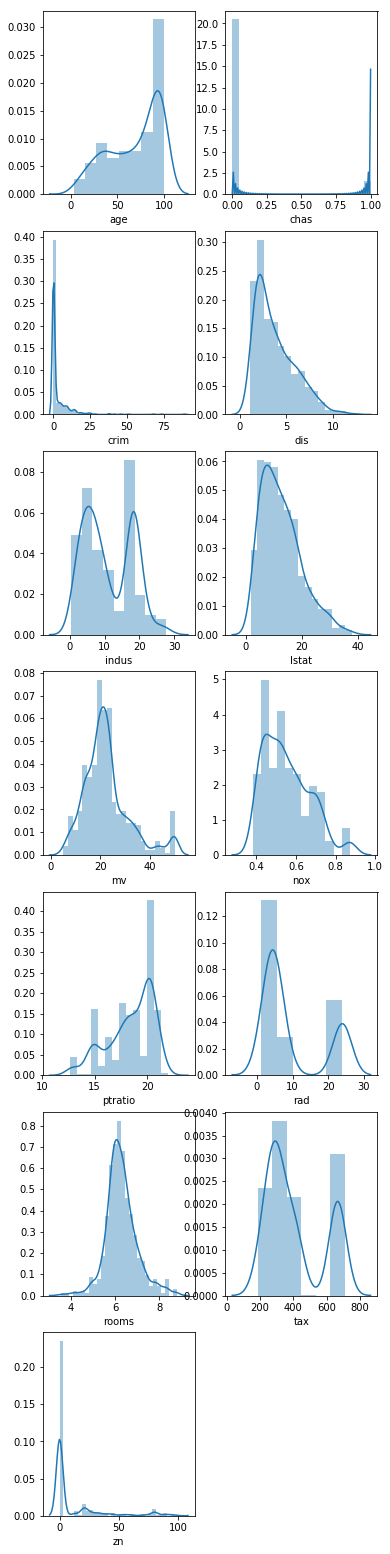

In [41]:
PlotCont(boston_input,cont)

# do eda on numeric variables, mostly continuous 

# mv - median values of homes (target)

# crim - crime rate
# zn (percent of zone land for lots)
# indus - percent of business that is industrial
# chas on charles river or not
# nox - air pollution conecntration
# rooms, average number of rooms
# age - percentage of homes before 1940
# dis - weighted distance to employment center
# rad - accessibility to radial highways
# tax - tax rate
# ptratio - pupil/teacher ratio
# lstat - percentage of population of low status


C:\Users\jjonus\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


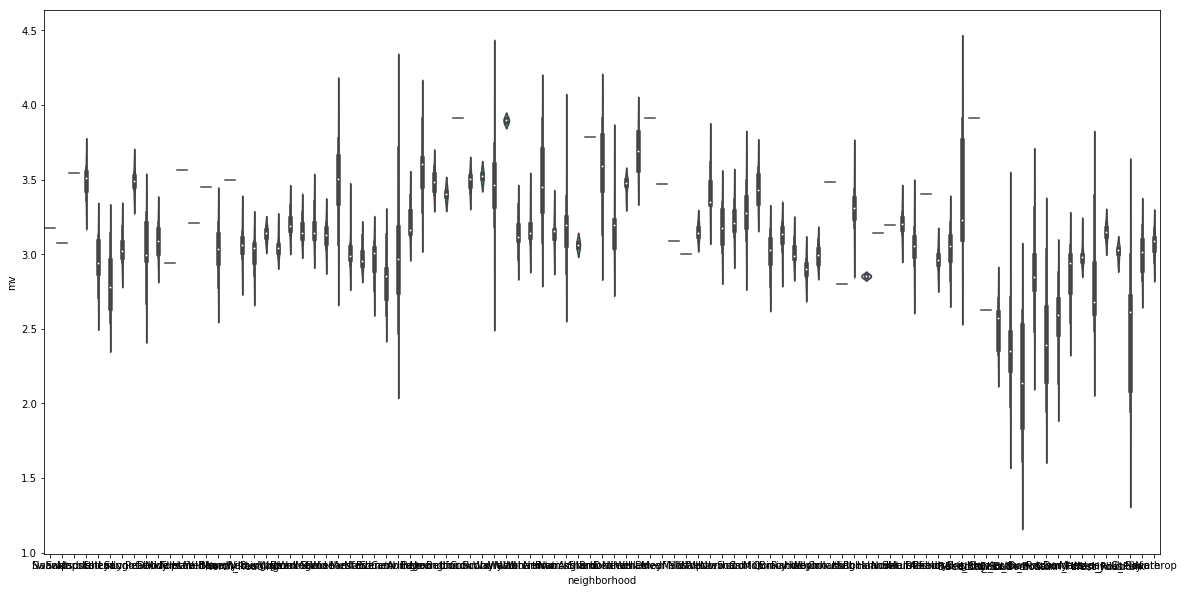

In [42]:
# look at values

plt.figure(figsize=(20,10))
sns.violinplot(x=boston_input.neighborhood,y=np.log(boston_input.mv))

C:\Users\jjonus\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


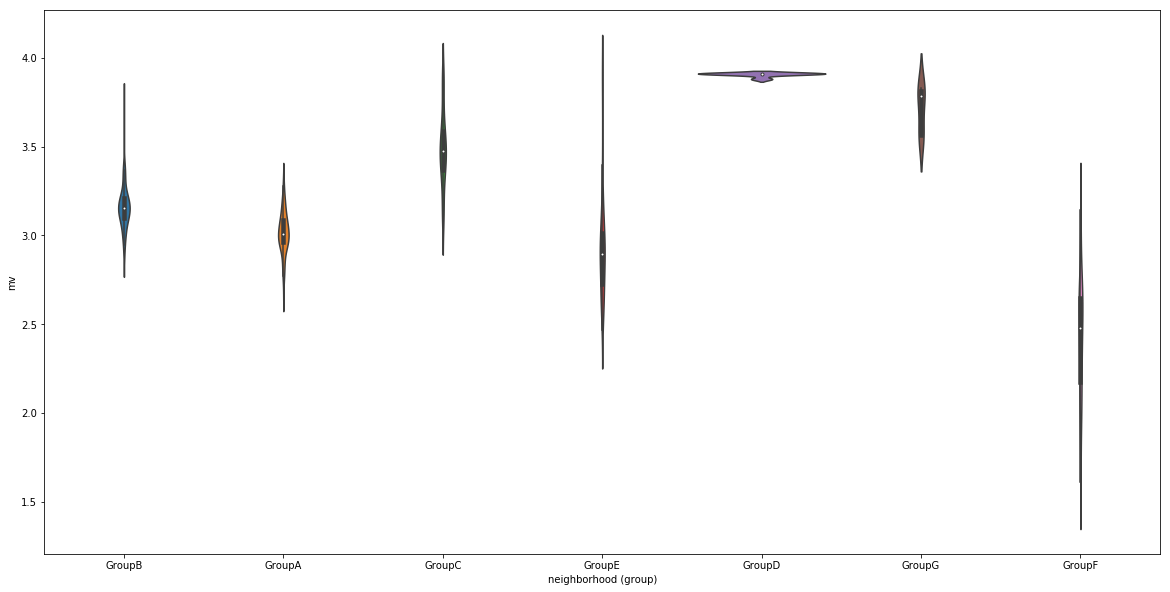

In [43]:
# in tableau, I manually grouped these to larger groups

plt.figure(figsize=(20,10))
sns.violinplot(x=boston_input['neighborhood (group)'],y=np.log(boston_input.mv))


C:\Users\jjonus\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


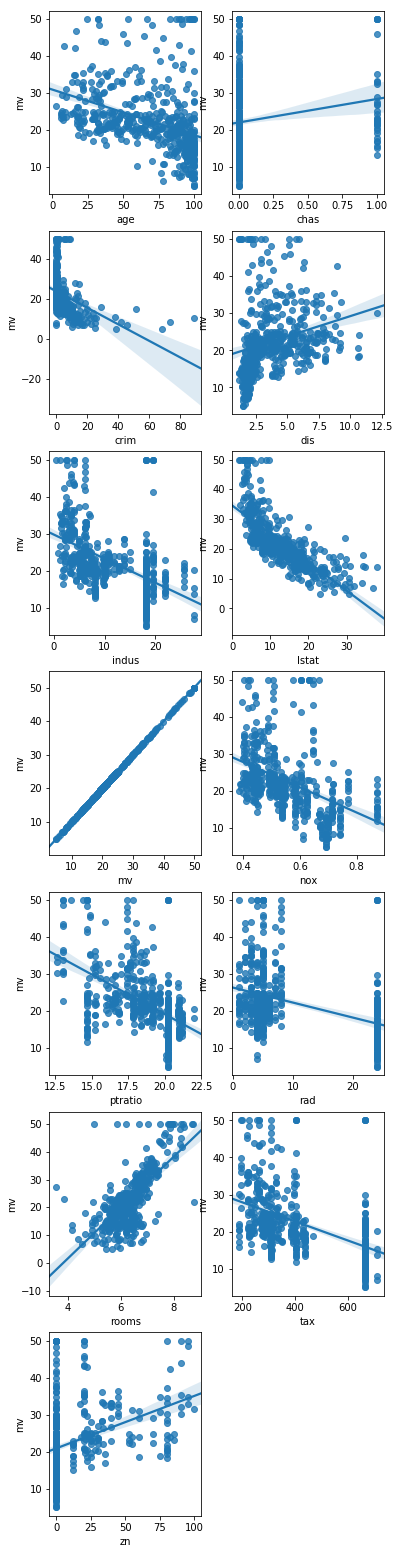

In [44]:
PlotContRegress(boston_input,'mv',cont)

# crim - crime rate
# zn (percent of zone land for lots)
# indus - percent of business that is industrial
# chas on charles river or not
# nox - air pollution conecntration
# rooms, average number of rooms
# age - percentage of homes before 1940
# dis - weighted distance to employment center
# rad - accessibility to radial highways
# tax - tax rate
# ptratio - pupil/teacher ratio
# lstat - percentage of population of low status


C:\Users\jjonus\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


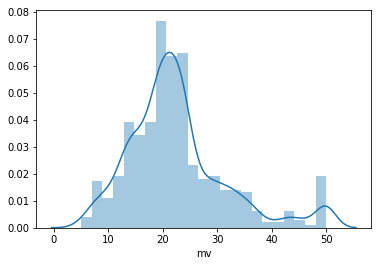

In [45]:
sns.distplot(boston_input.mv)

In [7]:
# transform the y variable using log
# drop neighborhood (too sparse), using group neighborhood

X = boston_input.copy()
X.drop(['neighborhood (group)','mv'],axis=1,inplace=True)
y = np.log(boston_input.mv)


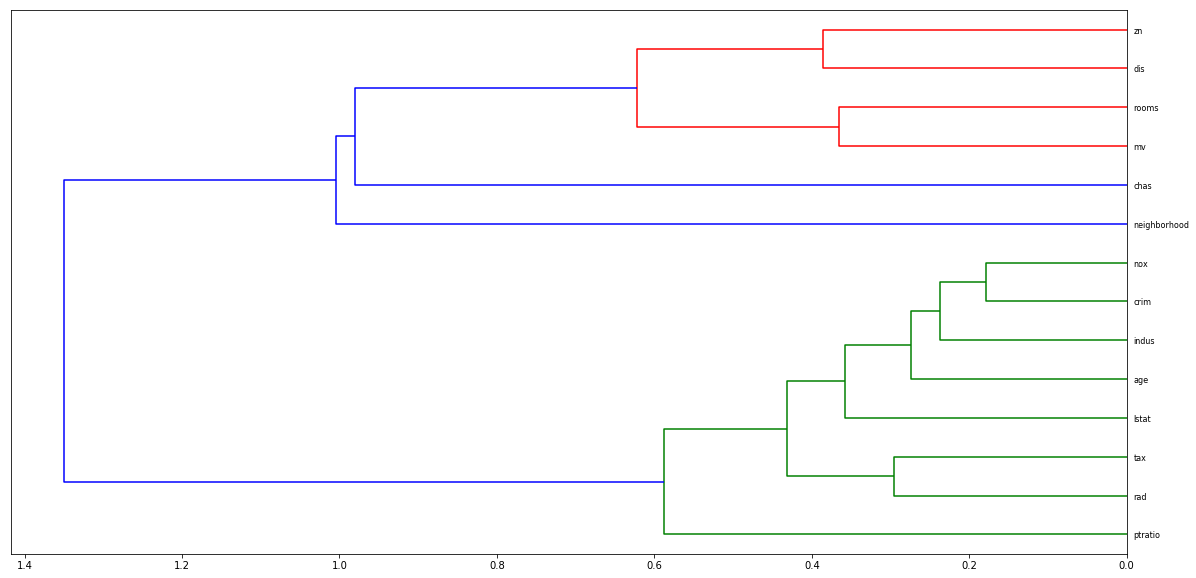

In [113]:
from scipy.cluster import hierarchy as hc
from rfpimp import feature_corr_matrix
pear_corr(X_data)

In [22]:
# import modelling components and then use pdp to analyze highly correlated variables and potential interactions

from sklearn.preprocessing import StandardScaler,MinMaxScaler,MaxAbsScaler,PolynomialFeatures
from sklearn.linear_model import Lasso,Ridge,ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,RepeatedKFold,train_test_split
from sklearn.pipeline import Pipeline

X_train = pd.get_dummies(X,drop_first=True)

# check to see if test set is representative of train ( for generalization)
print(X_train.describe().T)



                           count        mean         std        min  \
age                        506.0   68.574901   28.148861    2.90000   
chas                       506.0    0.069170    0.253994    0.00000   
crim                       506.0    3.613524    8.601545    0.00632   
dis                        506.0    3.795043    2.105710    1.12960   
indus                      506.0   11.136779    6.860353    0.46000   
lstat                      506.0   12.653063    7.141062    1.73000   
nox                        506.0    0.554695    0.115878    0.38500   
ptratio                    506.0   18.455534    2.164946   12.60000   
rad                        506.0    9.549407    8.707259    1.00000   
rooms                      506.0    6.284634    0.702617    3.56100   
tax                        506.0  408.237154  168.537116  187.00000   
zn                         506.0   11.363636   23.322453    0.00000   
neighborhood_Arlington     506.0    0.013834    0.116917    0.00000   
neighb

In [23]:
# spot check models
import warnings
from matplotlib import pyplot
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score,StratifiedKFold,RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import TheilSenRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import make_scorer,mean_squared_error

rkfold = RepeatedKFold(n_splits=3, n_repeats=3)

def rmse_cv(y_true, y_pred) : 
    assert len(y_true) == len(y_pred)
    if not (y_true >= 0).all() and not (y_pred >= 0).all():
        raise ValueError("Mean Squared Logarithmic Error cannot be used when "
                         "targets contain negative values.")
    y_pred = np.exp(y_pred)
    y_true = np.exp(y_true)
    return np.sqrt(mean_squared_error(y_true,y_pred))

rmse_cv = make_scorer(rmse_cv,greater_is_better=False)

In [27]:
# create a dict of standard models to evaluate {name:object}

import numpy as np

def get_models(models=dict()):
	# linear models
	models['lr'] = LinearRegression()
	alpha = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
	for a in alpha:
		models['lasso-'+str(a)] = Lasso(alpha=a)
	for a in alpha:
		models['ridge-'+str(a)] = Ridge(alpha=a)
	for a1 in alpha:
		for a2 in alpha:
			name = 'en-' + str(a1) + '-' + str(a2)
			models[name] = ElasticNet(a1, a2)
	models['huber'] = HuberRegressor()
	models['lars'] = Lars()
	models['llars'] = LassoLars()
	models['pa'] = PassiveAggressiveRegressor(max_iter=1000, tol=1e-3)
	models['ranscac'] = RANSACRegressor()
	models['sgd'] = SGDRegressor(max_iter=1000, tol=1e-3)
	models['theil'] = TheilSenRegressor()
	# non-linear models
	n_neighbors = range(1, 21)
	for k in n_neighbors:
		models['knn-'+str(k)] = KNeighborsRegressor(n_neighbors=k)
	models['cart'] = DecisionTreeRegressor()
	models['extra'] = ExtraTreeRegressor()
	models['svml'] = SVR(kernel='linear')
	c_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
	for c in c_values:
		models['svmr'+str(c)] = SVR(C=c)
	# ensemble models
	n_trees = 100
	models['ada'] = AdaBoostRegressor(n_estimators=n_trees)
	models['bag'] = BaggingRegressor(n_estimators=n_trees)
	models['rf'] = RandomForestRegressor(n_estimators=n_trees)
	models['et'] = ExtraTreesRegressor(n_estimators=n_trees)
	models['gbm'] = GradientBoostingRegressor(n_estimators=n_trees)
	print('Defined %d models' % len(models))
	return models
 
# create a feature preparation pipeline for a model
def make_pipeline(model):
	steps = list()
	# standardization
	steps.append(('standardize', StandardScaler()))
	# normalization
	steps.append(('normalize', MinMaxScaler()))
	# the model
	steps.append(('model', model))
	# create pipeline
	pipeline = Pipeline(steps=steps)
	return pipeline
 
# evaluate a single model
def evaluate_model(X, y, model, metric):
	# create the pipeline
	pipeline = make_pipeline(model)
	# evaluate model
	scores = cross_val_score(pipeline, X, y, scoring=metric, cv=rkfold, n_jobs=1)
	return scores
 
# evaluate a model and try to trap errors and and hide warnings
def robust_evaluate_model(X, y, model, metric):
	scores = None
	try:
		with warnings.catch_warnings():
			warnings.filterwarnings("ignore")
			scores = evaluate_model(X, y, model,metric)
	except:
		scores = None
	return scores
 
# evaluate a dict of models {name:object}, returns {name:score}
def evaluate_models(X, y, models, metric='accuracy'):
	results = dict()
	for name, model in models.items():
		# evaluate the model
		scores = robust_evaluate_model(X, y, model, metric)
		# show process
		if scores is not None:
			# store a result
			results[name] = scores
			mean_score, std_score = np.mean(scores), np.std(scores)
			print('>%s: %.3f (+/-%.3f)' % (name, mean_score, std_score))
		else:
			print('>%s: error' % name)
	return results
 
# print and plot the top n results
def summarize_results(results, maximize=True, top_n=20):
	# check for no results
	if len(results) == 0:
		print('no results')
		return
	# determine how many results to summarize
	n = min(top_n, len(results))
	# create a list of (name, mean(scores)) tuples
	mean_scores = [(k,np.mean(v)) for k,v in results.items()]
	# sort tuples by mean score
	mean_scores = sorted(mean_scores, key=lambda x: x[1])
	# reverse for descending order (e.g. for accuracy)
	if maximize:
		mean_scores = list(reversed(mean_scores))
	# retrieve the top n for summarization
	names = [x[0] for x in mean_scores[:n]]
	scores = [results[x[0]] for x in mean_scores[:n]]
	# print the top n
	print()
	for i in range(n):
		name = names[i]
		mean_score, std_score = np.mean(results[name]), np.std(results[name])
		print('Rank=%d, Name=%s, Score=%.3f (+/- %.3f)' % (i+1, name, mean_score, std_score))
	# boxplot for the top n
	pyplot.boxplot(scores, labels=names)
	_, labels = pyplot.xticks()
	pyplot.setp(labels, rotation=90)
	pyplot.savefig('spotcheck.png')
 
 

In [30]:
# load dataset
# get model list
models = get_models()


Defined 189 models


In [28]:
print(X.shape)
print(y.shape)

(506, 13)
(506,)


In [31]:
# evaluate models
results = evaluate_models(X_train, y, models,metric=rmse_cv)
# summarize results


>lr: error
>lasso-0.0: -4.045 (+/-0.540)
>lasso-0.1: -9.350 (+/-0.724)
>lasso-0.2: -9.335 (+/-0.395)
>lasso-0.3: -9.323 (+/-0.695)
>lasso-0.4: -9.333 (+/-0.517)
>lasso-0.5: -9.335 (+/-0.421)
>lasso-0.6: -9.339 (+/-0.541)
>lasso-0.7: -9.361 (+/-0.588)
>lasso-0.8: -9.332 (+/-0.491)
>lasso-0.9: -9.332 (+/-0.629)
>lasso-1.0: -9.323 (+/-0.707)
>ridge-0.0: error
>ridge-0.1: -3.876 (+/-0.526)
>ridge-0.2: -4.018 (+/-0.745)
>ridge-0.3: -3.967 (+/-0.819)
>ridge-0.4: -3.972 (+/-0.498)
>ridge-0.5: -4.153 (+/-0.615)
>ridge-0.6: -3.906 (+/-0.547)
>ridge-0.7: -3.889 (+/-0.311)
>ridge-0.8: -3.740 (+/-0.519)
>ridge-0.9: -3.958 (+/-0.588)
>ridge-1.0: -3.924 (+/-0.366)
>en-0.0-0.0: -3.789 (+/-0.569)
>en-0.0-0.1: -4.012 (+/-0.582)
>en-0.0-0.2: -3.880 (+/-0.847)
>en-0.0-0.3: -4.083 (+/-1.023)
>en-0.0-0.4: -4.370 (+/-0.747)
>en-0.0-0.5: -4.117 (+/-0.882)
>en-0.0-0.6: -4.172 (+/-0.797)
>en-0.0-0.7: -3.893 (+/-0.628)
>en-0.0-0.8: -4.066 (+/-0.503)
>en-0.0-0.9: -4.202 (+/-0.802)
>en-0.0-1.0: -4.086 (+/-0.741)



Rank=1, Name=et, Score=-3.020 (+/- 0.423)
Rank=2, Name=gbm, Score=-3.286 (+/- 0.417)
Rank=3, Name=bag, Score=-3.456 (+/- 0.633)
Rank=4, Name=rf, Score=-3.665 (+/- 0.510)
Rank=5, Name=svml, Score=-3.724 (+/- 0.611)
Rank=6, Name=ridge-0.8, Score=-3.740 (+/- 0.519)
Rank=7, Name=en-0.0-0.0, Score=-3.789 (+/- 0.569)
Rank=8, Name=ridge-0.1, Score=-3.876 (+/- 0.526)
Rank=9, Name=en-0.0-0.2, Score=-3.880 (+/- 0.847)
Rank=10, Name=ridge-0.7, Score=-3.889 (+/- 0.311)
Rank=11, Name=en-0.0-0.7, Score=-3.893 (+/- 0.628)
Rank=12, Name=ridge-0.6, Score=-3.906 (+/- 0.547)
Rank=13, Name=ridge-1.0, Score=-3.924 (+/- 0.366)
Rank=14, Name=huber, Score=-3.956 (+/- 1.074)
Rank=15, Name=ridge-0.9, Score=-3.958 (+/- 0.588)
Rank=16, Name=ridge-0.3, Score=-3.967 (+/- 0.819)
Rank=17, Name=ridge-0.4, Score=-3.972 (+/- 0.498)
Rank=18, Name=ada, Score=-3.992 (+/- 0.316)
Rank=19, Name=theil, Score=-4.006 (+/- 0.668)
Rank=20, Name=en-0.0-0.1, Score=-4.012 (+/- 0.582)


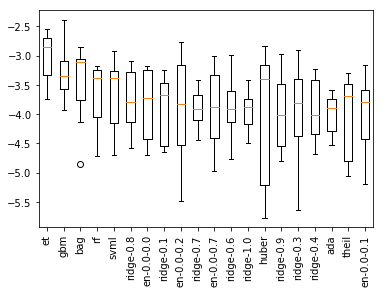

In [32]:
summarize_results(results)

In [34]:
# nothing done with the above but just interested to see the independent effects of the variables
# run elastic net first using standard scaler

etree = ExtraTreesRegressor()



params = ({'n_estimators': [50,100,150,200],
         'max_depth':[3,5,7,9],
         'max_features':[0.4,0.5,0.6]})


gs = GridSearchCV(etree,param_grid=params,cv=rkfold,scoring=rmse_cv,n_jobs=1)

gs.fit(X_train,y)
print(gs.best_score_)
print(gs.best_estimator_)



-3.0960684441274235
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=9,
          max_features=0.6, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
          oob_score=False, random_state=None, verbose=0, warm_start=False)


In [35]:
rf = RandomForestRegressor()



params =({'n_estimators': [50,100,150,200],
         'max_depth':[3,5,7,9],
         'max_features':[0.4,0.5,0.6]})


gs2 = GridSearchCV(rf,param_grid=params,cv=rkfold,scoring=rmse_cv,n_jobs=1)

gs2.fit(X_train,y)
print(gs2.best_score_)
print(gs2.best_estimator_)



-3.402338410253697
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


In [37]:
# run with max abs scaler

gb = GradientBoostingRegressor()

params =({'n_estimators': [50,100,150,200],
         'max_depth':[3,5,7,9],
         'max_features':[0.4,0.5,0.6],
          'loss':['ls','lad','huber','quantile']})


gs3 = GridSearchCV(gb,param_grid=params,cv=rkfold,scoring=rmse_cv,n_jobs=1)

gs3.fit(X_train,y)
print(gs3.best_score_)
print(gs3.best_estimator_)




KeyboardInterrupt: 

In [ ]:
import warnings

warnings.filterwarnings("ignore")
# nothing done with the above but just interested to see the independent effects of the variables
# run elastic net first using standard scaler

from sklearn.feature_selection import SelectKBest,f_regression

k_best = SelectKBest(f_regression)

etree = ExtraTreesRegressor()


params = ({'k_best__k':range(1,12,1),
          'etree__n_estimators': [50,100,150,200],
         'etree__max_depth':[3,5,7,9],
         'etree__max_features':[0.4,0.5,0.6]})

etree_pipe = Pipeline([('k_best',k_best),
                      ('etree',etree)])

gs = GridSearchCV(etree_pipe,param_grid=params,cv=rkfold,scoring=rmse_cv,n_jobs=1)

gs.fit(X_train,y)
print(gs.best_score_)
print(gs.best_estimator_)



In [127]:

from sklearn.feature_selection import SelectKBest,f_regression

k_best = SelectKBest(f_regression)

rf = RandomForestRegressor()


params = ({'k_best__k':range(1,12,1),
          'rf__n_estimators': [50,100,150,200],
         'rf__max_depth':[3,5,7,9],
         'rf__max_features':[0.4,0.5,0.6]})

rf_pipe = Pipeline([('k_best',k_best),
                      ('rf',rf)])

gs = GridSearchCV(rf_pipe,param_grid=params,cv=rkfold,scoring=rmse_cv,n_jobs=1)


gs.fit(X_train,y)
print(gs.best_score_)
print(gs.best_estimator_)



-3.463311715403092
Pipeline(memory=None,
     steps=[('k_best', SelectKBest(k=11, score_func=<function f_regression at 0x000000971463D2F0>)), ('rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
           max_features=0.6, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))])
-4.125461413771763


In [128]:
from sklearn.feature_selection import SelectKBest,f_regression

k_best = SelectKBest(f_regression)

gb = GradientBoostingRegressor()


params = ({'k_best__k':range(1,12,1),
          'gb__n_estimators': [50,100,150,200],
         'gb__max_depth':[3,5,7,9],
         'gb__max_features':[0.4,0.5,0.6],
          'gb__loss':['ls','lad','huber','quantile']})

gb_pipe = Pipeline([('k_best',k_best),
                      ('gb',gb)])

gs = GridSearchCV(gb_pipe,param_grid=params,cv=rkfold,scoring=rmse_cv,n_jobs=1)


gs.fit(X_train,y)
print(gs.best_score_)
print(gs.best_estimator_)


-3.4534288964359474
Pipeline(memory=None,
     steps=[('k_best', SelectKBest(k=10, score_func=<function f_regression at 0x000000971463D2F0>)), ('gb', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=5,
             max_features=0.6, max_leaf_nodes=None,
            ...     subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False))])


-3.845400656128242

In [149]:
# use tpot on data set with no feature engineering

from tpot import TPOTRegressor

custom_config =  {

    'sklearn.linear_model.ElasticNetCV': {
        'l1_ratio': np.arange(0.0, 1.01, 0.05),
        'tol': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
    },

    'sklearn.ensemble.ExtraTreesRegressor': {
        'n_estimators': [100],
        'max_features': np.arange(0.05, 1.01, 0.05),
        'min_samples_split': range(2, 21),
        'min_samples_leaf': range(1, 21),
        'bootstrap': [True, False]
    },

    'sklearn.ensemble.GradientBoostingRegressor': {
        'n_estimators': [100],
        'loss': ["ls", "lad", "huber", "quantile"],
        'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
        'max_depth': range(1, 11),
        'min_samples_split': range(2, 21),
        'min_samples_leaf': range(1, 21),
        'subsample': np.arange(0.05, 1.01, 0.05),
        'max_features': np.arange(0.05, 1.01, 0.05),
        'alpha': [0.75, 0.8, 0.85, 0.9, 0.95, 0.99]
    },

    'sklearn.ensemble.AdaBoostRegressor': {
        'n_estimators': [100],
        'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
        'loss': ["linear", "square", "exponential"]
    },

    'sklearn.tree.DecisionTreeRegressor': {
        'max_depth': range(1, 11),
        'min_samples_split': range(2, 21),
        'min_samples_leaf': range(1, 21)
    },

    'sklearn.neighbors.KNeighborsRegressor': {
        'n_neighbors': range(1, 101),
        'weights': ["uniform", "distance"],
        'p': [1, 2]
    },

    'sklearn.linear_model.LassoLarsCV': {
        'normalize': [True, False]
    },

    'sklearn.svm.LinearSVR': {
        'loss': ["epsilon_insensitive", "squared_epsilon_insensitive"],
        'dual': [True, False],
        'tol': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
        'C': [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1., 5., 10., 15., 20., 25.],
        'epsilon': [1e-4, 1e-3, 1e-2, 1e-1, 1.]
    },

    'sklearn.ensemble.RandomForestRegressor': {
        'n_estimators': [100],
        'max_features': np.arange(0.05, 1.01, 0.05),
        'min_samples_split': range(2, 21),
        'min_samples_leaf': range(1, 21),
        'bootstrap': [True, False]
    },

    'sklearn.linear_model.RidgeCV': {
    },

    # Preprocesssors
    'sklearn.preprocessing.Binarizer': {
        'threshold': np.arange(0.0, 1.01, 0.05)
    },

    'sklearn.decomposition.FastICA': {
        'tol': np.arange(0.0, 1.01, 0.05)
    },

    'sklearn.cluster.FeatureAgglomeration': {
        'linkage': ['ward', 'complete', 'average'],
        'affinity': ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']
    },

    'sklearn.preprocessing.MaxAbsScaler': {
    },

    'sklearn.preprocessing.MinMaxScaler': {
    },

    'sklearn.preprocessing.Normalizer': {
        'norm': ['l1', 'l2', 'max']
    },

    'sklearn.kernel_approximation.Nystroem': {
        'kernel': ['rbf', 'cosine', 'chi2', 'laplacian', 'polynomial', 'poly', 'linear', 'additive_chi2', 'sigmoid'],
        'gamma': np.arange(0.0, 1.01, 0.05),
        'n_components': range(1, 11)
    },

    'sklearn.decomposition.PCA': {
        'svd_solver': ['randomized'],
        'iterated_power': range(1, 11)
    },

    'sklearn.preprocessing.PolynomialFeatures': {
        'degree': [2],
        'include_bias': [False],
        'interaction_only': [False]
    },

    'sklearn.kernel_approximation.RBFSampler': {
        'gamma': np.arange(0.0, 1.01, 0.05)
    },

    'sklearn.preprocessing.RobustScaler': {
    },

    'sklearn.preprocessing.StandardScaler': {
    },

}


# add custom regressors

from tpot.config.regressor import regressor_config_dict

from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import TheilSenRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.base import RegressorMixin

#RANSACRegressor.__bases__ += (RegressorMixin,)
#SGDRegressor.__bases__ =+ (RegressorMixin,)
#TheilSenRegresssor.__bases__ =+ (RegressorMixin,)
#HuberRegressor.__bases__ =+ (RegressorMixin,)

custom_config['sklearn.linear_model.RANSACRegressor'] = {
    'loss':['absolute_loss','squared_loss']
}

custom_config['sklearn.linear_model.SGDRegressor'] = {
    'loss':['squared_loss','huber','epsilon_insensitive','squared_epsilon_insensitive'],
    'penalty':['none','l2','l1','elasticnet'],
    'alpha':[0.0001,0.00001,0.001],
    'learning_rate':['constant','optimal','invscaling','adaptive']
    
}

custom_config['sklearn.linear_model.TheilSenRegressor'] = {
    'n_jobs':[-1]
}

custom_config['sklearn.linear_model.HuberRegressor'] = {
    'epsilon':[1.1,1.2,1.3,1.35]
}


# new loss score for tpot

def rmse_cv(y_true, y_pred) : 
    assert len(y_true) == len(y_pred)
    y_pred = np.exp(y_pred)
    y_true = np.exp(y_true)
    return np.sqrt(mean_squared_error(y_true,y_pred))

rmse_cv = make_scorer(rmse_cv,greater_is_better=False)

tpot = TPOTRegressor(verbosity=3, config_dict= custom_config,
                     scoring = rmse_cv,cv = rkfold,
                     periodic_checkpoint_folder='C:\\Users\\jjonus\\Google Drive\\Boston Data Set\\NoEng', population_size=120,offspring_size= 120,
                     max_eval_time_mins=10)


tpot.fit(X_train.values,y_train)


26 operators have been imported by TPOT.


Created new folder to save periodic pipeline: C:\Users\jjonus\Google Drive\Boston Data Set\NoEng
Saving best periodic pipeline to C:\Users\jjonus\Google Drive\Boston Data Set\NoEng\pipeline_2018.12.20_12-50-48.py
_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False
_pre_test decorator: _random_mutation_operator: num_test=0 manhattan was provided as affinity. Ward can only work with euclidean distances.
_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False
_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_inse

_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 63
_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 63
Generation 9 - Current Pareto front scores:
-1	-3.236652028486718	GradientBoostingRegressor(input_matrix, GradientBoostingRegressor__alpha=0.9, GradientBoostingRegressor__learning_rate=0.1, GradientBoostingRegressor__loss=huber, GradientBoostingRegressor__max_depth=10, GradientBoostingRegressor__max_features=0.35000000000000003, GradientBoostingRegressor__min_samples_leaf=3, GradientBoostingRegressor__min_samples_split=17, GradientBoostingRegressor__n_estimators=100, GradientBoostingRegressor__subsample=0.7000000000000001)
-2	-3.064816556196949	RandomForestRegressor(CombineDFs(input_matrix, RidgeCV(input_matrix)), RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.15000000000000002, RandomForestRegre

-5	-3.044947193378696	LassoLarsCV(DecisionTreeRegressor(RobustScaler(RandomForestRegressor(RANSACRegressor(input_matrix, RANSACRegressor__loss=squared_loss), RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.35000000000000003, RandomForestRegressor__min_samples_leaf=2, RandomForestRegressor__min_samples_split=3, RandomForestRegressor__n_estimators=100)), DecisionTreeRegressor__max_depth=4, DecisionTreeRegressor__min_samples_leaf=10, DecisionTreeRegressor__min_samples_split=2), LassoLarsCV__normalize=False)
-7	-3.0227007218859385	HuberRegressor(PCA(RobustScaler(MinMaxScaler(RandomForestRegressor(RandomForestRegressor(RANSACRegressor(input_matrix, RANSACRegressor__loss=squared_loss), RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.2, RandomForestRegressor__min_samples_leaf=7, RandomForestRegressor__min_samples_split=3, RandomForestRegressor__n_estimators=100), RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_feat

-7	-3.0227007218859385	HuberRegressor(PCA(RobustScaler(MinMaxScaler(RandomForestRegressor(RandomForestRegressor(RANSACRegressor(input_matrix, RANSACRegressor__loss=squared_loss), RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.2, RandomForestRegressor__min_samples_leaf=7, RandomForestRegressor__min_samples_split=3, RandomForestRegressor__n_estimators=100), RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.35000000000000003, RandomForestRegressor__min_samples_leaf=2, RandomForestRegressor__min_samples_split=3, RandomForestRegressor__n_estimators=100))), PCA__iterated_power=8, PCA__svd_solver=randomized), HuberRegressor__epsilon=1.2)

Periodic pipeline was not saved, probably saved before...
_pre_test decorator: _random_mutation_operator: num_test=0 Automatic alpha grid generation is not supported for l1_ratio=0. Please supply a grid by providing your estimator with the appropriate `alphas=` argument.
_pre_test decorator: _random_

-4	-3.028948344172166	GradientBoostingRegressor(ExtraTreesRegressor(CombineDFs(input_matrix, RidgeCV(CombineDFs(input_matrix, RidgeCV(input_matrix)))), ExtraTreesRegressor__bootstrap=False, ExtraTreesRegressor__max_features=0.55, ExtraTreesRegressor__min_samples_leaf=1, ExtraTreesRegressor__min_samples_split=5, ExtraTreesRegressor__n_estimators=100), GradientBoostingRegressor__alpha=0.95, GradientBoostingRegressor__learning_rate=0.1, GradientBoostingRegressor__loss=huber, GradientBoostingRegressor__max_depth=5, GradientBoostingRegressor__max_features=0.45, GradientBoostingRegressor__min_samples_leaf=2, GradientBoostingRegressor__min_samples_split=7, GradientBoostingRegressor__n_estimators=100, GradientBoostingRegressor__subsample=0.9500000000000001)
-7	-3.0227007218859385	HuberRegressor(PCA(RobustScaler(MinMaxScaler(RandomForestRegressor(RandomForestRegressor(RANSACRegressor(input_matrix, RANSACRegressor__loss=squared_loss), RandomForestRegressor__bootstrap=False, RandomForestRegressor

-2	-3.0291192332226746	GradientBoostingRegressor(CombineDFs(input_matrix, ExtraTreesRegressor(input_matrix, ExtraTreesRegressor__bootstrap=False, ExtraTreesRegressor__max_features=0.55, ExtraTreesRegressor__min_samples_leaf=1, ExtraTreesRegressor__min_samples_split=5, ExtraTreesRegressor__n_estimators=100)), GradientBoostingRegressor__alpha=0.95, GradientBoostingRegressor__learning_rate=0.1, GradientBoostingRegressor__loss=ls, GradientBoostingRegressor__max_depth=5, GradientBoostingRegressor__max_features=0.35000000000000003, GradientBoostingRegressor__min_samples_leaf=2, GradientBoostingRegressor__min_samples_split=12, GradientBoostingRegressor__n_estimators=100, GradientBoostingRegressor__subsample=0.9500000000000001)
-4	-3.001115464624431	GradientBoostingRegressor(ExtraTreesRegressor(CombineDFs(input_matrix, RidgeCV(CombineDFs(input_matrix, TheilSenRegressor(input_matrix, TheilSenRegressor__n_jobs=-1)))), ExtraTreesRegressor__bootstrap=False, ExtraTreesRegressor__max_features=0.55, 

-5	-2.9563755161141354	LassoLarsCV(ExtraTreesRegressor(AdaBoostRegressor(RandomForestRegressor(RANSACRegressor(input_matrix, RANSACRegressor__loss=squared_loss), RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.35000000000000003, RandomForestRegressor__min_samples_leaf=2, RandomForestRegressor__min_samples_split=3, RandomForestRegressor__n_estimators=100), AdaBoostRegressor__learning_rate=0.5, AdaBoostRegressor__loss=exponential, AdaBoostRegressor__n_estimators=100), ExtraTreesRegressor__bootstrap=True, ExtraTreesRegressor__max_features=0.1, ExtraTreesRegressor__min_samples_leaf=17, ExtraTreesRegressor__min_samples_split=4, ExtraTreesRegressor__n_estimators=100), LassoLarsCV__normalize=True)

Saving best periodic pipeline to C:\Users\jjonus\Google Drive\Boston Data Set\NoEng\pipeline_2018.12.20_17-48-04.py
Generation 38 - Current Pareto front scores:
-1	-3.1749201141040753	GradientBoostingRegressor(input_matrix, GradientBoostingRegressor__alpha=0.95, Gradie

-5	-2.9563755161141354	LassoLarsCV(ExtraTreesRegressor(AdaBoostRegressor(RandomForestRegressor(RANSACRegressor(input_matrix, RANSACRegressor__loss=squared_loss), RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.35000000000000003, RandomForestRegressor__min_samples_leaf=2, RandomForestRegressor__min_samples_split=3, RandomForestRegressor__n_estimators=100), AdaBoostRegressor__learning_rate=0.5, AdaBoostRegressor__loss=exponential, AdaBoostRegressor__n_estimators=100), ExtraTreesRegressor__bootstrap=True, ExtraTreesRegressor__max_features=0.1, ExtraTreesRegressor__min_samples_leaf=17, ExtraTreesRegressor__min_samples_split=4, ExtraTreesRegressor__n_estimators=100), LassoLarsCV__normalize=True)

Periodic pipeline was not saved, probably saved before...
_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 75
_pre_test decorator: _random_mutation_operator: num_test=0 manhattan was provid

-4	-2.9765010350891163	GradientBoostingRegressor(ExtraTreesRegressor(CombineDFs(input_matrix, CombineDFs(input_matrix, RidgeCV(LinearSVR(input_matrix, LinearSVR__C=25.0, LinearSVR__dual=True, LinearSVR__epsilon=0.01, LinearSVR__loss=squared_epsilon_insensitive, LinearSVR__tol=1e-05)))), ExtraTreesRegressor__bootstrap=False, ExtraTreesRegressor__max_features=0.55, ExtraTreesRegressor__min_samples_leaf=1, ExtraTreesRegressor__min_samples_split=5, ExtraTreesRegressor__n_estimators=100), GradientBoostingRegressor__alpha=0.95, GradientBoostingRegressor__learning_rate=0.1, GradientBoostingRegressor__loss=huber, GradientBoostingRegressor__max_depth=6, GradientBoostingRegressor__max_features=0.45, GradientBoostingRegressor__min_samples_leaf=2, GradientBoostingRegressor__min_samples_split=7, GradientBoostingRegressor__n_estimators=100, GradientBoostingRegressor__subsample=0.9500000000000001)
-5	-2.9563755161141354	LassoLarsCV(ExtraTreesRegressor(AdaBoostRegressor(RandomForestRegressor(RANSACReg

-5	-2.9563755161141354	LassoLarsCV(ExtraTreesRegressor(AdaBoostRegressor(RandomForestRegressor(RANSACRegressor(input_matrix, RANSACRegressor__loss=squared_loss), RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.35000000000000003, RandomForestRegressor__min_samples_leaf=2, RandomForestRegressor__min_samples_split=3, RandomForestRegressor__n_estimators=100), AdaBoostRegressor__learning_rate=0.5, AdaBoostRegressor__loss=exponential, AdaBoostRegressor__n_estimators=100), ExtraTreesRegressor__bootstrap=True, ExtraTreesRegressor__max_features=0.1, ExtraTreesRegressor__min_samples_leaf=17, ExtraTreesRegressor__min_samples_split=4, ExtraTreesRegressor__n_estimators=100), LassoLarsCV__normalize=True)

Periodic pipeline was not saved, probably saved before...
_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 56
_pre_test decorator: _random_mutation_operator: num_test=0 manhattan was provid

-5	-2.9563755161141354	LassoLarsCV(ExtraTreesRegressor(AdaBoostRegressor(RandomForestRegressor(RANSACRegressor(input_matrix, RANSACRegressor__loss=squared_loss), RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.35000000000000003, RandomForestRegressor__min_samples_leaf=2, RandomForestRegressor__min_samples_split=3, RandomForestRegressor__n_estimators=100), AdaBoostRegressor__learning_rate=0.5, AdaBoostRegressor__loss=exponential, AdaBoostRegressor__n_estimators=100), ExtraTreesRegressor__bootstrap=True, ExtraTreesRegressor__max_features=0.1, ExtraTreesRegressor__min_samples_leaf=17, ExtraTreesRegressor__min_samples_split=4, ExtraTreesRegressor__n_estimators=100), LassoLarsCV__normalize=True)

Periodic pipeline was not saved, probably saved before...
_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 64
_pre_test decorator: _random_mutation_operator: num_test=0 `min_samples` may no

-1	-3.1665186097363494	GradientBoostingRegressor(input_matrix, GradientBoostingRegressor__alpha=0.95, GradientBoostingRegressor__learning_rate=0.1, GradientBoostingRegressor__loss=huber, GradientBoostingRegressor__max_depth=5, GradientBoostingRegressor__max_features=0.45, GradientBoostingRegressor__min_samples_leaf=1, GradientBoostingRegressor__min_samples_split=17, GradientBoostingRegressor__n_estimators=100, GradientBoostingRegressor__subsample=0.9500000000000001)
-2	-3.0291192332226746	GradientBoostingRegressor(CombineDFs(input_matrix, ExtraTreesRegressor(input_matrix, ExtraTreesRegressor__bootstrap=False, ExtraTreesRegressor__max_features=0.55, ExtraTreesRegressor__min_samples_leaf=1, ExtraTreesRegressor__min_samples_split=5, ExtraTreesRegressor__n_estimators=100)), GradientBoostingRegressor__alpha=0.95, GradientBoostingRegressor__learning_rate=0.1, GradientBoostingRegressor__loss=ls, GradientBoostingRegressor__max_depth=5, GradientBoostingRegressor__max_features=0.3500000000000000

-2	-3.0291192332226746	GradientBoostingRegressor(CombineDFs(input_matrix, ExtraTreesRegressor(input_matrix, ExtraTreesRegressor__bootstrap=False, ExtraTreesRegressor__max_features=0.55, ExtraTreesRegressor__min_samples_leaf=1, ExtraTreesRegressor__min_samples_split=5, ExtraTreesRegressor__n_estimators=100)), GradientBoostingRegressor__alpha=0.95, GradientBoostingRegressor__learning_rate=0.1, GradientBoostingRegressor__loss=ls, GradientBoostingRegressor__max_depth=5, GradientBoostingRegressor__max_features=0.35000000000000003, GradientBoostingRegressor__min_samples_leaf=2, GradientBoostingRegressor__min_samples_split=12, GradientBoostingRegressor__n_estimators=100, GradientBoostingRegressor__subsample=0.9500000000000001)
-4	-2.9765010350891163	GradientBoostingRegressor(ExtraTreesRegressor(CombineDFs(input_matrix, CombineDFs(input_matrix, RidgeCV(LinearSVR(input_matrix, LinearSVR__C=25.0, LinearSVR__dual=True, LinearSVR__epsilon=0.01, LinearSVR__loss=squared_epsilon_insensitive, LinearSV

-4	-2.9765010350891163	GradientBoostingRegressor(ExtraTreesRegressor(CombineDFs(input_matrix, CombineDFs(input_matrix, RidgeCV(LinearSVR(input_matrix, LinearSVR__C=25.0, LinearSVR__dual=True, LinearSVR__epsilon=0.01, LinearSVR__loss=squared_epsilon_insensitive, LinearSVR__tol=1e-05)))), ExtraTreesRegressor__bootstrap=False, ExtraTreesRegressor__max_features=0.55, ExtraTreesRegressor__min_samples_leaf=1, ExtraTreesRegressor__min_samples_split=5, ExtraTreesRegressor__n_estimators=100), GradientBoostingRegressor__alpha=0.95, GradientBoostingRegressor__learning_rate=0.1, GradientBoostingRegressor__loss=huber, GradientBoostingRegressor__max_depth=6, GradientBoostingRegressor__max_features=0.45, GradientBoostingRegressor__min_samples_leaf=2, GradientBoostingRegressor__min_samples_split=7, GradientBoostingRegressor__n_estimators=100, GradientBoostingRegressor__subsample=0.9500000000000001)
-5	-2.9563755161141354	LassoLarsCV(ExtraTreesRegressor(AdaBoostRegressor(RandomForestRegressor(RANSACReg

_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Generation 73 - Current Pareto front scores:
-1	-3.151763652723502	GradientBoostingRegressor(input_matrix, GradientBoostingRegressor__alpha=0.95, GradientBoostingRegressor__learning_rate=0.1, GradientBoostingRegressor__loss=huber, GradientBoostingRegressor__max_depth=5, GradientBoostingRegressor__max_features=0.45, GradientBoostingRegressor__min_samples_leaf=1, GradientBoostingRegressor__min_samples_split=12, GradientBoostingRegressor__n_estimators=100, GradientBoostingRegressor__subsample=0.9500000000000001)
-2	-3.0291192332226746	GradientBoostingRegressor(CombineDFs(input_matrix, ExtraTreesRegressor(inpu

-4	-2.9765010350891163	GradientBoostingRegressor(ExtraTreesRegressor(CombineDFs(input_matrix, CombineDFs(input_matrix, RidgeCV(LinearSVR(input_matrix, LinearSVR__C=25.0, LinearSVR__dual=True, LinearSVR__epsilon=0.01, LinearSVR__loss=squared_epsilon_insensitive, LinearSVR__tol=1e-05)))), ExtraTreesRegressor__bootstrap=False, ExtraTreesRegressor__max_features=0.55, ExtraTreesRegressor__min_samples_leaf=1, ExtraTreesRegressor__min_samples_split=5, ExtraTreesRegressor__n_estimators=100), GradientBoostingRegressor__alpha=0.95, GradientBoostingRegressor__learning_rate=0.1, GradientBoostingRegressor__loss=huber, GradientBoostingRegressor__max_depth=6, GradientBoostingRegressor__max_features=0.45, GradientBoostingRegressor__min_samples_leaf=2, GradientBoostingRegressor__min_samples_split=7, GradientBoostingRegressor__n_estimators=100, GradientBoostingRegressor__subsample=0.9500000000000001)
-5	-2.9563755161141354	LassoLarsCV(ExtraTreesRegressor(AdaBoostRegressor(RandomForestRegressor(RANSACReg

-2	-3.0058163522503545	RandomForestRegressor(ExtraTreesRegressor(input_matrix, ExtraTreesRegressor__bootstrap=False, ExtraTreesRegressor__max_features=0.6500000000000001, ExtraTreesRegressor__min_samples_leaf=1, ExtraTreesRegressor__min_samples_split=12, ExtraTreesRegressor__n_estimators=100), RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.55, RandomForestRegressor__min_samples_leaf=1, RandomForestRegressor__min_samples_split=6, RandomForestRegressor__n_estimators=100)
-4	-2.9765010350891163	GradientBoostingRegressor(ExtraTreesRegressor(CombineDFs(input_matrix, CombineDFs(input_matrix, RidgeCV(LinearSVR(input_matrix, LinearSVR__C=25.0, LinearSVR__dual=True, LinearSVR__epsilon=0.01, LinearSVR__loss=squared_epsilon_insensitive, LinearSVR__tol=1e-05)))), ExtraTreesRegressor__bootstrap=False, ExtraTreesRegressor__max_features=0.55, ExtraTreesRegressor__min_samples_leaf=1, ExtraTreesRegressor__min_samples_split=5, ExtraTreesRegressor__n_estimators=100), Gradie

_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 67
_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 53
_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 82
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Generation 87 - Current Pareto front scores:
-1	-3.151763652723502	GradientBoostingRegressor(input_matrix, GradientBoostingRegressor__alpha=0.95, GradientBoostingRegressor__learning_rate=0.1, GradientBoostingRegressor__loss=huber, GradientBoostingRegressor__max_depth=5, GradientBoostingRegressor__max_features=0.45, GradientBoostingRegressor__min_samples_leaf=1, GradientBoostingRegressor__min_samples_split=12, GradientBoostingRegressor__n_estimators=100, GradientBoo

_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 51
_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 73
_pre_test decorator: _random_mutation_operator: num_test=0 array must not contain infs or NaNs
_pre_test decorator: _random_mutation_operator: num_test=0 array must not contain infs or NaNs
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Generation 91 - Current Pareto front scores:
-1	-3.151560325248063	GradientBoostingRegressor(input_matrix, GradientBoostingRegressor__alpha=0.75, GradientBoostingRegressor__learning_rate=0.1, GradientBoostingRegressor__loss=ls, GradientBoostingRegressor__max_depth=10, Gradien

-4	-2.9765010350891163	GradientBoostingRegressor(ExtraTreesRegressor(CombineDFs(input_matrix, CombineDFs(input_matrix, RidgeCV(LinearSVR(input_matrix, LinearSVR__C=25.0, LinearSVR__dual=True, LinearSVR__epsilon=0.01, LinearSVR__loss=squared_epsilon_insensitive, LinearSVR__tol=1e-05)))), ExtraTreesRegressor__bootstrap=False, ExtraTreesRegressor__max_features=0.55, ExtraTreesRegressor__min_samples_leaf=1, ExtraTreesRegressor__min_samples_split=5, ExtraTreesRegressor__n_estimators=100), GradientBoostingRegressor__alpha=0.95, GradientBoostingRegressor__learning_rate=0.1, GradientBoostingRegressor__loss=huber, GradientBoostingRegressor__max_depth=6, GradientBoostingRegressor__max_features=0.45, GradientBoostingRegressor__min_samples_leaf=2, GradientBoostingRegressor__min_samples_split=7, GradientBoostingRegressor__n_estimators=100, GradientBoostingRegressor__subsample=0.9500000000000001)
-5	-2.9563755161141354	LassoLarsCV(ExtraTreesRegressor(AdaBoostRegressor(RandomForestRegressor(RANSACReg

-6	-2.9002816351110186	RandomForestRegressor(RidgeCV(AdaBoostRegressor(ExtraTreesRegressor(RandomForestRegressor(RANSACRegressor(input_matrix, RANSACRegressor__loss=squared_loss), RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.35000000000000003, RandomForestRegressor__min_samples_leaf=2, RandomForestRegressor__min_samples_split=3, RandomForestRegressor__n_estimators=100), ExtraTreesRegressor__bootstrap=True, ExtraTreesRegressor__max_features=0.15000000000000002, ExtraTreesRegressor__min_samples_leaf=14, ExtraTreesRegressor__min_samples_split=17, ExtraTreesRegressor__n_estimators=100), AdaBoostRegressor__learning_rate=0.001, AdaBoostRegressor__loss=exponential, AdaBoostRegressor__n_estimators=100)), RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.15000000000000002, RandomForestRegressor__min_samples_leaf=1, RandomForestRegressor__min_samples_split=5, RandomForestRegressor__n_estimators=100)

Periodic pipeline was not saved, pr

TPOTRegressor(config_dict={'sklearn.linear_model.ElasticNetCV': {'l1_ratio': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]), 'tol': [1e-05, 0.0001, 0.001, 0.01, 0.1]}, 'sklearn.ensemble.ExtraTreesRegressor': {'n_estimato...essor': {'n_jobs': [-1]}, 'sklearn.linear_model.HuberRegressor': {'epsilon': [1.1, 1.2, 1.3, 1.35]}},
       crossover_rate=0.1,
       cv=<sklearn.model_selection._split.RepeatedKFold object at 0x0000009718B9C550>,
       disable_update_check=False, early_stop=None, generations=100,
       max_eval_time_mins=10, max_time_mins=None, memory=None,
       mutation_rate=0.9, n_jobs=1, offspring_size=120,
       periodic_checkpoint_folder='C:\\Users\\jjonus\\Google Drive\\Boston Data Set\\NoEng',
       population_size=120, random_state=None,
       scoring=make_scorer(rmse_cv, greater_is_better=False),
       subsample=0.8, use_dask=False, verbosity=3, warm_start=False)

9 outliers:
[166, 401, 416, 374, 391, 364, 369, 399, 400]
8 outliers:
[426, 441, 371, 401, 374, 397, 391, 399]


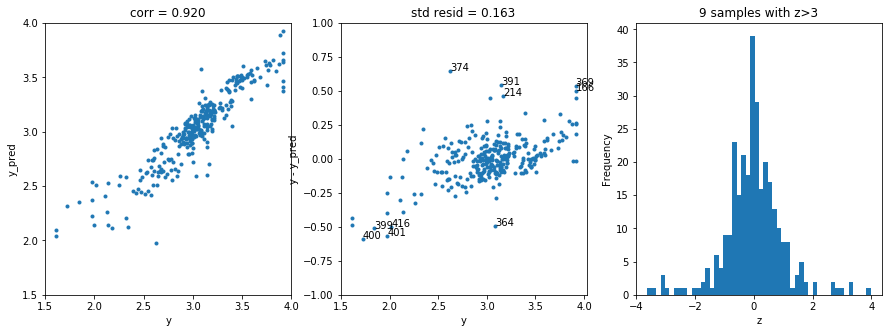

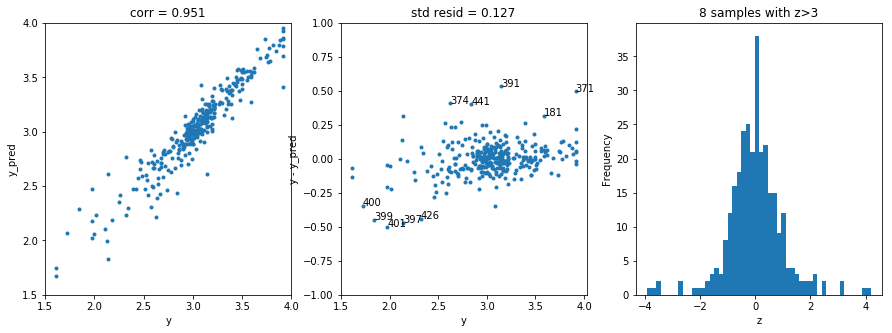

In [380]:
## showing residual plots of 2 best models
    
## residual plots with 11 best variables (2nd best)

residual_plot(elnet_first,X_sc1,y_train)

## residual plots with polynomial features, 49 total ( best model)

residual_plot(elnet_final,X_sc2,y_train)